In [1]:
import torch_geometric.transforms as T
from torch_geometric.nn import graclus, max_pool, global_mean_pool
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
import matplotlib.pyplot as plt
import numpy as np
import utils
from torch_geometric.data import Data, Batch, DataLoader
from IPython.display import display, clear_output
import time

In [2]:
train_data = torch.load("data/MNISTSuperpixels_train_data.pt")
print(train_data[0])
test_data = torch.load("data/MNISTSuperpixels_test_data.pt")
print(test_data[0])

Data(edge_index=[2, 472], label=5, pos=[77, 2], x=[77, 3])
Data(edge_index=[2, 488], label=3, pos=[81, 2], x=[81, 3])


In [3]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)

In [4]:
rotation_0 = T.RandomRotate(degrees=180, axis=0)
rotation_1 = T.RandomRotate(degrees=180, axis=1)
rotation_2 = T.RandomRotate(degrees=180, axis=2)

In [5]:
NUM_NODE_FEATURES = 3
NUM_CLASSES = 10

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(NUM_NODE_FEATURES, 12)
        self.conv2 = GCNConv(12, 24)
        self.conv3 = GCNConv(24, 12)
        self.linear = nn.Linear(12, NUM_CLASSES)
        
#         >>> m = nn.AvgPool2d(3, stride=2)
# >>> # pool of non-square window
# >>> m = nn.AvgPool2d((3, 2), stride=(2, 1))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv3(x, edge_index)
        
        x = global_mean_pool(x, data.batch)
        
        x = self.linear(x)
#         x = F.relu(x)
#         x = self.linear2(x)

        return F.log_softmax(x)

In [7]:
print(len(test_data))

10000


In [8]:
model = Net()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
def evaluate():
    model.eval()
    acc = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        _, predicts = out.max(dim=1)
        targets = torch.tensor(data.label).to(device)
        correct = torch.eq(predicts, targets).sum().item()
        acc += correct
    acc /= len(test_data)
    return acc

In [12]:
acc = evaluate()
print(acc)

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0.0967


In [13]:
loss_hist = []
acc_hist = []

for i in range(100):
    
    model.train()
    total_loss = 0
    
    for data in train_loader:     
        
        
        data = data.to(device)
        out = model(data)
#         out = out.reshape((1,10)).to(device)
        target = torch.tensor(data.label).to(device)
        
        optimizer.zero_grad()
        loss = F.nll_loss(out, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    acc = evaluate()
    loss_hist.append(total_loss)
    acc_hist.append(acc)
    print("Ep:", i, "Loss:", total_loss, "Acc:", acc)

C:\Users\Ukasz\Anaconda3\envs\gdl\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Ep: 0 Loss: 1548.658515572548 Acc: 0.3477
Ep: 1 Loss: 1400.4042782783508 Acc: 0.3696
Ep: 2 Loss: 1319.859770655632 Acc: 0.4602
Ep: 3 Loss: 1293.8583031892776 Acc: 0.4836
Ep: 4 Loss: 1253.6523121595383 Acc: 0.5101
Ep: 5 Loss: 1207.7012578248978 Acc: 0.5608
Ep: 6 Loss: 1172.7122653722763 Acc: 0.5753
Ep: 7 Loss: 1135.1575815677643 Acc: 0.6386
Ep: 8 Loss: 1100.2982981204987 Acc: 0.5702
Ep: 9 Loss: 1071.5555999279022 Acc: 0.6524
Ep: 10 Loss: 1047.1750967502594 Acc: 0.6559
Ep: 11 Loss: 1036.6210398077965 Acc: 0.6733
Ep: 12 Loss: 1022.5719775557518 Acc: 0.6894
Ep: 13 Loss: 1012.688056409359 Acc: 0.6804
Ep: 14 Loss: 1016.5748320221901 Acc: 0.7008
Ep: 15 Loss: 1006.4430186748505 Acc: 0.7142
Ep: 16 Loss: 999.0073153972626 Acc: 0.6453
Ep: 17 Loss: 993.5368751883507 Acc: 0.6573
Ep: 18 Loss: 986.0555467009544 Acc: 0.6426
Ep: 19 Loss: 980.804057776928 Acc: 0.7065
Ep: 20 Loss: 980.8385877013206 Acc: 0.6979
Ep: 21 Loss: 972.2628401517868 Acc: 0.668
Ep: 22 Loss: 970.8127064704895 Acc: 0.7144
Ep: 23 Los

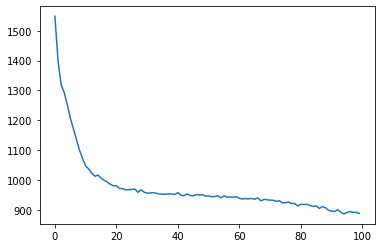

In [14]:
plt.plot(loss_hist)
plt.show()

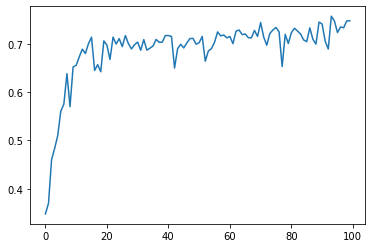

In [15]:
plt.plot(acc_hist)
plt.show()